# **모델 성능 최적화**


## **1. 환경준비**

In [1]:
# 라이브러리 로딩
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

# 디바이스 준비
device = 'cuda' if torch.cuda.is_available() else 'cpu'

* 딥러닝을 위한 데이터로더 만들기

In [2]:
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :
    # 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # TensorDataset 생성: 텐서 데이터 세트로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)
    return train_loader, x_val_tensor, y_val_tensor

* 학습을 위한 함수

In [3]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset) # 전체 데이터 세트의 크기
    num_batches = len(dataloader) # 배치 크기
    tr_loss = 0

    model.train() # 학습 모드로 설정
    for x, y in dataloader: # 배치 단위로 로딩
        x, y = x.to(device), y.to(device) # 디바이스 지정

        # Feed Forward(오차 순전파)
        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        # Backpropagation(오차 역전파)
        loss.backward() # 역전파를 통해 각 파라미터에 대한 오차의 기울기 계산
        optimizer.step() # 옵티마이저가 모델의 파라미터를 업데이트
        optimizer.zero_grad() # 옵티마이저의 기울기값 초기화.

    tr_loss /= num_batches # 모든 배치의 오차 평균
    return tr_loss.item()

* 검증을 위한 함수

In [4]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval() # 모델을 평가 모드로 설정

    with torch.no_grad(): # 평가 과정에서 기울기를 계산하지 않도록 설정
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred, y).item() # 예측값 pred와 목푯값 y 사이의 오차 계산

    return eval_loss, pred

* 학습곡선

In [5]:
def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list)+1)) # 에포크 수 계산
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.') # 학습 오차 그래프
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.') # 검증 오차 그래프
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

## **2. 모델 성능 최적화 실습 1: 과적합 모델**

### (1) 데이터 전처리

* 데이터 세트 다운로드

In [6]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_dataset = datasets.FashionMNIST(root='data', train=True, download=True,
transform=ToTensor())
test_dataset = datasets.FashionMNIST(root='data', train=False, download=True,
transform=ToTensor())

100%|██████████| 26.4M/26.4M [00:01<00:00, 13.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.71MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 31.1MB/s]


In [7]:
class_list = train_dataset.classes
class_list

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

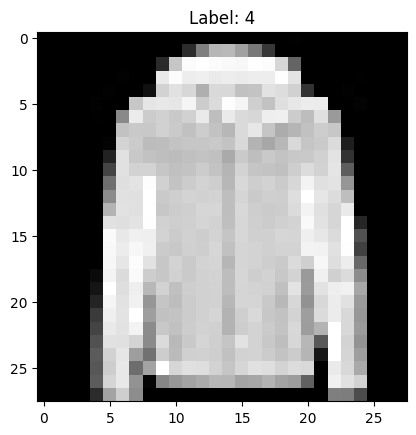

In [8]:
n = 5000
image, label = train_dataset.data[n], train_dataset.targets[n]

# 이미지 시각화
plt.imshow(image, cmap='gray')
plt.title(f'Label: {label}')
plt.show()

* 데이터 세트의 원본 데이터 추출 및 스케일링

In [9]:
x_train = train_dataset.data / 255
y_train = train_dataset.targets
x_test = test_dataset.data / 255
y_test = test_dataset.targets

* 학습 데이터의 크기 줄이기, 테스트 데이터 분할

In [10]:
x_train = x_train[:20000]
y_train = y_train[:20000]
print(x_train.shape)

torch.Size([20000, 28, 28])


In [11]:
x_val, x_test = x_test[:5000], x_test[5000:]
y_val, y_test = y_test[:5000], y_test[5000:]
print(x_val.shape, x_test.shape)

torch.Size([5000, 28, 28]) torch.Size([5000, 28, 28])


* 이미지 데이터의 차원 맞추기, 데이터 로더 구성

In [12]:
x_train = x_train.view(20000, 1, 28, 28)
x_val = x_val.view(5000, 1, 28, 28)
x_test = x_test.view(5000, 1, 28, 28)

In [13]:
train_TensorDS = TensorDataset(x_train, y_train)
batch_size = 64
train_loader = DataLoader(train_TensorDS, batch_size=batch_size)

### (2) 과적합 모델 만들기

* 복잡한 모델 구조

In [14]:
n_feature = 28 * 28
n_class = 10
# 모델 구조 설계
model = nn.Sequential(nn.Flatten(),
        nn.Linear(n_feature, 512), nn.ReLU(),
        nn.Linear(512, 256), nn.ReLU(),
        nn.Linear(256, 256), nn.ReLU(),
        nn.Linear(256, 64), nn.ReLU(),
        nn.Linear(64, n_class)
        ).to(device)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

* 모델 요약

In [16]:
from torchsummary import summary
summary(model, input_size = (n_feature,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 512]         401,920
              ReLU-3                  [-1, 512]               0
            Linear-4                  [-1, 256]         131,328
              ReLU-5                  [-1, 256]               0
            Linear-6                  [-1, 256]          65,792
              ReLU-7                  [-1, 256]               0
            Linear-8                   [-1, 64]          16,448
              ReLU-9                   [-1, 64]               0
           Linear-10                   [-1, 10]             650
Total params: 616,138
Trainable params: 616,138
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.35
Estimated T

* 학습

Epoch 1, train loss : 0.7542, val loss : 0.5778
Epoch 2, train loss : 0.4728, val loss : 0.4958
Epoch 3, train loss : 0.4061, val loss : 0.4532
Epoch 4, train loss : 0.3719, val loss : 0.4276
Epoch 5, train loss : 0.3424, val loss : 0.4207
Epoch 6, train loss : 0.3184, val loss : 0.4279
Epoch 7, train loss : 0.3029, val loss : 0.4207
Epoch 8, train loss : 0.2887, val loss : 0.4536
Epoch 9, train loss : 0.2713, val loss : 0.4292
Epoch 10, train loss : 0.2613, val loss : 0.4434
Epoch 11, train loss : 0.2488, val loss : 0.4595
Epoch 12, train loss : 0.2366, val loss : 0.4806
Epoch 13, train loss : 0.2308, val loss : 0.4864
Epoch 14, train loss : 0.2214, val loss : 0.4731
Epoch 15, train loss : 0.2060, val loss : 0.4772
Epoch 16, train loss : 0.2031, val loss : 0.4843
Epoch 17, train loss : 0.1971, val loss : 0.4852
Epoch 18, train loss : 0.2002, val loss : 0.4849
Epoch 19, train loss : 0.1802, val loss : 0.5137
Epoch 20, train loss : 0.1747, val loss : 0.5058
Epoch 21, train loss : 0.1676

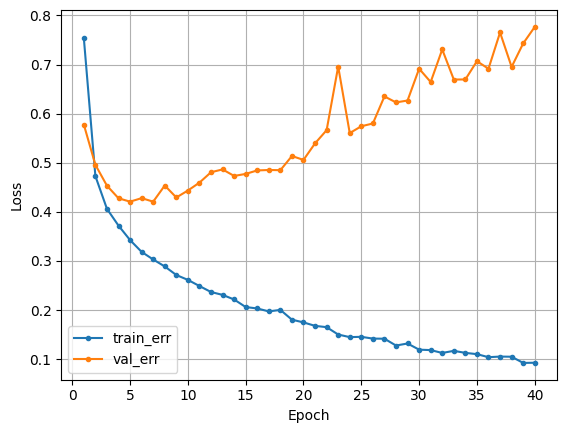

In [17]:
epochs = 40
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss, pred = evaluate(x_val, y_val, model, loss_fn, device)
    # 리스트에 추가
    tr_loss_list.append(tr_loss) # train - CrossEntropy
    val_loss_list.append(val_loss) # val - CrossEntropy
    print(f'Epoch {t+1}, train loss : {tr_loss:.4f}, val loss : {val_loss:.4f}')

# 학습 곡선
dl_learning_curve(tr_loss_list, val_loss_list)

* 모델 예측 및 평가

In [18]:
# 예측하고 소프트맥스 함수 적용
_, pred = evaluate(x_test, y_test, model, loss_fn, device)
pred = nn.functional.softmax(pred, dim=1)

# 가장 확률이 높은 인덱스 저장
pred = np.argmax(pred.cpu().numpy(), axis = 1)

# 모델 평가
print(classification_report(y_test, pred, target_names=class_list, digits=4))

              precision    recall  f1-score   support

 T-shirt/top     0.7854    0.8093    0.7972       493
     Trouser     0.9959    0.9383    0.9663       519
    Pullover     0.8141    0.7495    0.7804       479
       Dress     0.8918    0.8740    0.8828       500
        Coat     0.7646    0.8205    0.7915       479
      Sandal     0.9779    0.9437    0.9605       515
       Shirt     0.6595    0.7143    0.6858       518
     Sneaker     0.9026    0.9820    0.9406       500
         Bag     0.9805    0.9536    0.9668       474
  Ankle boot     0.9758    0.9235    0.9489       523

    accuracy                         0.8714      5000
   macro avg     0.8748    0.8709    0.8721      5000
weighted avg     0.8756    0.8714    0.8727      5000



## **3. 모델 성능 최적화 실습 2: 조기 종료**

* 모델 선언

In [19]:
n_class = 10
model1= nn.Sequential(nn.Flatten(),
            nn.Linear(n_feature, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, n_class)
            ).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model1.parameters(), lr=0.001)

* 조기 종료 코드 구현

In [20]:
# 1. 조기 종료를 위한 변수 설정 ----------------
patience = 5
best_loss = float('inf')
counter = 0
tr_loss_list, val_loss_list = [], []
for t in range(40):
    tr_loss = train(train_loader, model1, loss_fn, optimizer, device)
    val_loss, pred = evaluate(x_val, y_val, model1, loss_fn, device)
    pred = nn.functional.softmax(pred, dim=1)
    pred = np.argmax(pred.cpu().numpy(), axis = 1)
    tr_loss_list.append(tr_loss) # train - CrossEntropy
    val_loss_list.append(val_loss) # val - CrossEntropy
    print(f'Epoch {t+1}, train loss : {tr_loss:.4f}, val loss : {val_loss:.4f}')

    # 2. 조기 종료 확인 -------------------
    if val_loss > best_loss:
        counter += 1
        print(f'--> status, best_loss : {best_loss:4f}, counter : {counter}')
    else:
        best_loss = val_loss
        counter = 0
    # 3. 조기 종료 조건 확인 --------------------
    if counter >= patience:
        print('Early Stopping!')
        break

Epoch 1, train loss : 0.7605, val loss : 0.5611
Epoch 2, train loss : 0.4776, val loss : 0.4979
Epoch 3, train loss : 0.4162, val loss : 0.4840
Epoch 4, train loss : 0.3766, val loss : 0.4266
Epoch 5, train loss : 0.3498, val loss : 0.4012
Epoch 6, train loss : 0.3221, val loss : 0.4039
--> status, best_loss : 0.401169, counter : 1
Epoch 7, train loss : 0.3035, val loss : 0.4171
--> status, best_loss : 0.401169, counter : 2
Epoch 8, train loss : 0.2866, val loss : 0.4034
--> status, best_loss : 0.401169, counter : 3
Epoch 9, train loss : 0.2671, val loss : 0.4282
--> status, best_loss : 0.401169, counter : 4
Epoch 10, train loss : 0.2593, val loss : 0.4307
--> status, best_loss : 0.401169, counter : 5
Early Stopping!


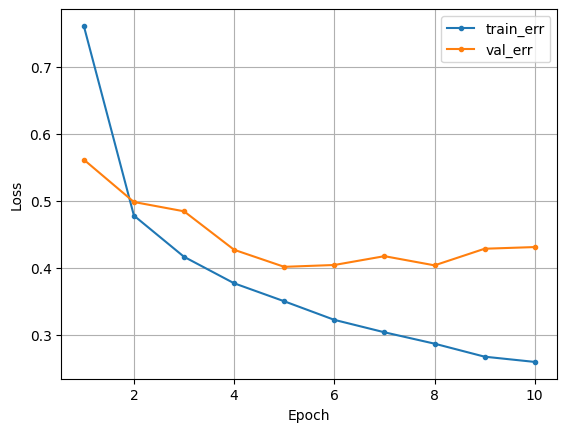

In [21]:
dl_learning_curve(tr_loss_list, val_loss_list)

* 예측 및 평가 결과

In [22]:
# 예측하고 소프트맥스 함수 적용
_, pred = evaluate(x_test, y_test, model1, loss_fn, device)
pred = nn.functional.softmax(pred, dim=1)

# 가장 확률이 높은 인덱스 저장
pred = np.argmax(pred.cpu().numpy(), axis = 1)

# 모델 평가
print(classification_report(y_test, pred, target_names=class_list, digits=4))

              precision    recall  f1-score   support

 T-shirt/top     0.8389    0.8134    0.8260       493
     Trouser     0.9900    0.9518    0.9705       519
    Pullover     0.7045    0.8163    0.7563       479
       Dress     0.9126    0.8140    0.8605       500
        Coat     0.6952    0.8142    0.7500       479
      Sandal     0.9683    0.9476    0.9578       515
       Shirt     0.7360    0.6081    0.6660       518
     Sneaker     0.8991    0.9620    0.9295       500
         Bag     0.9416    0.9873    0.9640       474
  Ankle boot     0.9678    0.9197    0.9431       523

    accuracy                         0.8632      5000
   macro avg     0.8654    0.8634    0.8624      5000
weighted avg     0.8672    0.8632    0.8632      5000



## **4. 모델 성능 최적화 실습 3: 드롭아웃**

* 드롭아웃 모델 설계

In [23]:
n_feature = 28 * 28
n_class = 10
dropout_rate = 0.4

model2 = nn.Sequential(nn.Flatten(),
            nn.Linear(n_feature, 512), nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256), nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 256), nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 64), nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, n_class)
            ).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model2.parameters(), lr=0.001)

* 학습

Epoch 1, train loss : 1.0283, val loss : 0.5919
Epoch 2, train loss : 0.6223, val loss : 0.5115
Epoch 3, train loss : 0.5439, val loss : 0.4614
Epoch 4, train loss : 0.5101, val loss : 0.4600
Epoch 5, train loss : 0.4788, val loss : 0.4224
Epoch 6, train loss : 0.4584, val loss : 0.4207
Epoch 7, train loss : 0.4466, val loss : 0.4386
Epoch 8, train loss : 0.4345, val loss : 0.4239
Epoch 9, train loss : 0.4242, val loss : 0.4265
Epoch 10, train loss : 0.4100, val loss : 0.4221
Epoch 11, train loss : 0.4050, val loss : 0.4114
Epoch 12, train loss : 0.4007, val loss : 0.3948
Epoch 13, train loss : 0.3901, val loss : 0.3983
Epoch 14, train loss : 0.3798, val loss : 0.4097
Epoch 15, train loss : 0.3729, val loss : 0.4041
Epoch 16, train loss : 0.3648, val loss : 0.3971
Epoch 17, train loss : 0.3641, val loss : 0.4063
Epoch 18, train loss : 0.3538, val loss : 0.4054
Epoch 19, train loss : 0.3518, val loss : 0.4071
Epoch 20, train loss : 0.3536, val loss : 0.4026
Epoch 21, train loss : 0.3502

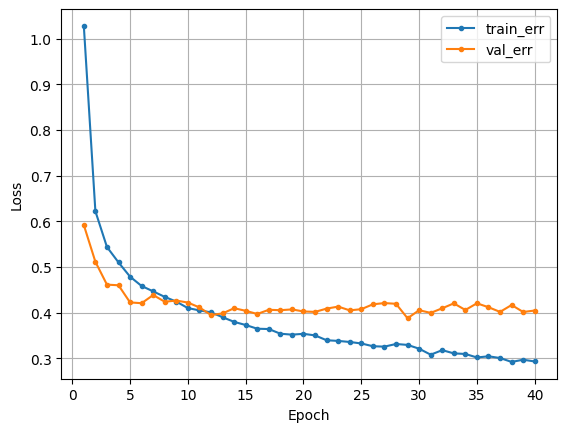

In [24]:
epochs = 40
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model2, loss_fn, optimizer, device)
    val_loss, pred = evaluate(x_val, y_val, model2, loss_fn, device)
    # 리스트에 추가
    tr_loss_list.append(tr_loss) # train - CrossEntropy
    val_loss_list.append(val_loss) # val - CrossEntropy
    print(f'Epoch {t+1}, train loss : {tr_loss:.4f}, val loss : {val_loss:.4f}')

dl_learning_curve(tr_loss_list, val_loss_list)

* 예측 및 평가

In [25]:
# 모델 예측
_, pred = evaluate(x_test, y_test, model2, loss_fn, device)
pred = nn.functional.softmax(pred, dim=1)
pred = np.argmax(pred.cpu().numpy(), axis = 1)

# 모델 평가
print(classification_report(y_test.numpy(), pred, target_names=class_list, digits=4))

              precision    recall  f1-score   support

 T-shirt/top     0.8058    0.8499    0.8272       493
     Trouser     0.9940    0.9538    0.9735       519
    Pullover     0.8237    0.7411    0.7802       479
       Dress     0.8598    0.9080    0.8833       500
        Coat     0.7002    0.8434    0.7652       479
      Sandal     0.9721    0.9476    0.9597       515
       Shirt     0.7647    0.6274    0.6893       518
     Sneaker     0.9065    0.9700    0.9372       500
         Bag     0.9628    0.9831    0.9729       474
  Ankle boot     0.9680    0.9254    0.9462       523

    accuracy                         0.8750      5000
   macro avg     0.8758    0.8750    0.8735      5000
weighted avg     0.8771    0.8750    0.8742      5000



## **5. 모델 성능 최적화 실습 4: 가중치 규제**

* L2 규제 코드 적용하기

In [26]:
n_feature = 28 * 28
n_class = 10

model3 = nn.Sequential(nn.Flatten(),
            nn.Linear(n_feature, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, n_class)
            ).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model3.parameters(), lr=0.001, weight_decay = 0.001)

* 학습

Epoch 1, train loss : 0.7766, val loss : 0.5586
Epoch 2, train loss : 0.5119, val loss : 0.5334
Epoch 3, train loss : 0.4546, val loss : 0.4960
Epoch 4, train loss : 0.4230, val loss : 0.4737
Epoch 5, train loss : 0.3978, val loss : 0.4634
Epoch 6, train loss : 0.3768, val loss : 0.4695
Epoch 7, train loss : 0.3620, val loss : 0.4602
Epoch 8, train loss : 0.3495, val loss : 0.4359
Epoch 9, train loss : 0.3386, val loss : 0.4380
Epoch 10, train loss : 0.3289, val loss : 0.4462
Epoch 11, train loss : 0.3177, val loss : 0.4362
Epoch 12, train loss : 0.3104, val loss : 0.4219
Epoch 13, train loss : 0.3032, val loss : 0.4256
Epoch 14, train loss : 0.2972, val loss : 0.4348
Epoch 15, train loss : 0.2889, val loss : 0.4393
Epoch 16, train loss : 0.2817, val loss : 0.4523
Epoch 17, train loss : 0.2750, val loss : 0.4557
Epoch 18, train loss : 0.2715, val loss : 0.4255
Epoch 19, train loss : 0.2690, val loss : 0.4362
Epoch 20, train loss : 0.2651, val loss : 0.4374
Epoch 21, train loss : 0.2578

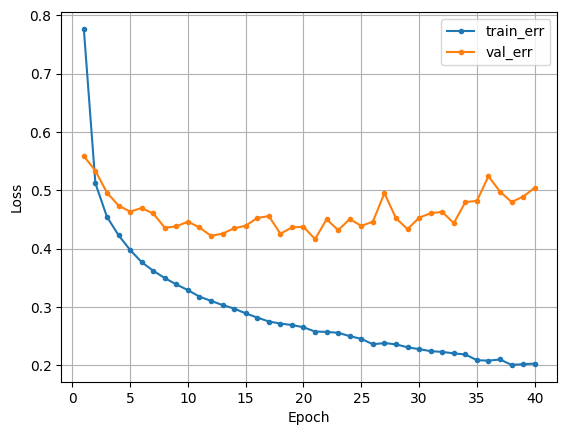

In [27]:
epochs = 40
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model3, loss_fn, optimizer, device)
    val_loss, pred = evaluate(x_val, y_val, model3, loss_fn, device)
    tr_loss_list.append(tr_loss) # train - CrossEntropy
    val_loss_list.append(val_loss) # val - CrossEntropy
    print(f'Epoch {t+1}, train loss : {tr_loss:.4f}, val loss : {val_loss:.4f}')

dl_learning_curve(tr_loss_list, val_loss_list)

* 예측 및 평가

In [28]:
# 모델 예측
_, pred = evaluate(x_test, y_test, model3, loss_fn, device)
pred = nn.functional.softmax(pred, dim=1)
pred = np.argmax(pred.cpu().numpy(), axis = 1)

In [29]:
# 모델 평가
print(classification_report(y_test.numpy(), pred, target_names=class_list, digits=4))

              precision    recall  f1-score   support

 T-shirt/top     0.8618    0.7586    0.8069       493
     Trouser     0.9779    0.9383    0.9577       519
    Pullover     0.7225    0.8100    0.7638       479
       Dress     0.9167    0.7700    0.8370       500
        Coat     0.7151    0.8121    0.7605       479
      Sandal     0.9084    0.9631    0.9350       515
       Shirt     0.6464    0.6776    0.6616       518
     Sneaker     0.9055    0.9200    0.9127       500
         Bag     0.9479    0.9599    0.9539       474
  Ankle boot     0.9612    0.9006    0.9299       523

    accuracy                         0.8512      5000
   macro avg     0.8563    0.8510    0.8519      5000
weighted avg     0.8574    0.8512    0.8525      5000

